Use the provided Jupyter notebook to implement your code. Rename the notebook to
(DATA255_Assignment3_Name_SJSU_ID) and submit it before the due time.


Report the performance of each network in terms of test accuracy and also plot the validation loss vs
train loss, and validation accuracy vs train accuracy for all of the following tasks.


For all the following variants you need to add an Embedding layer as the first layer. Here is a good
explanation for what embedding layer does. https://stats.stackexchange.com/questions/270546/howdoes-
keras-embedding-layer-work


For TensorFlow you can use: https://keras.io/api/layers/core_layers/embedding/
For PyTorch use: https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html


The parameters for embedding layer: embedding_dim=64, num_embeddings/ input_dim(Keras)
=10000 since we only kept the 10000 most frequent words. (Please refer to provided Jupyter
notebook)

## now you have your training, validation and test set as numpy arrays, you can implement the networks

The parameters for embedding layer: embedding_dim=64, num_embeddings/ input_dim(Keras) 
=10000 since we only kept the 10000 most frequent words. (Please refer to provided Jupyter 
notebook) 

In [3]:
import pandas as pd
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer


# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of encodings to try
encodings_to_try = ['utf-8', 'latin1', 'iso-8859-1']

for encoding in encodings_to_try:
    try:
        df = pd.read_csv("IMDB_Dataset.csv", encoding=encoding)
        break  # Break the loop if successful
    except UnicodeDecodeError:
        print("Failed to read with encoding '{}'".format(encoding))
        continue

# Display the first few rows of the DataFrame
df.head()

# Cleaning up the text
nltk.download("stopwords")
stopWords = set(nltk.corpus.stopwords.words("english"))

def CleanText(text):
    text = text.lower() 
    text = re.sub("[^a-z]", " ", text)
    words = [word for word in text.split() if word not in stopWords]
    text = " ".join(words)
    return text

df["review"] = df.apply(lambda row: CleanText(row["review"]), axis=1)
Data = df.review
labels = df.sentiment

Failed to read with encoding 'utf-8'


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:


# Convert labels to numerical values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Convert text data to sequences
frequentWord = 10000
tokenizer = Tokenizer(num_words=frequentWord)
tokenizer.fit_on_texts(Data)
IntegerizedData = tokenizer.texts_to_sequences(Data)

# Zero padding
maxlen = 256
IntegerizedData = pad_sequences(IntegerizedData, maxlen=maxlen)


In [5]:
# Train-validation-test split
x_train_val, x_test, y_train_val, y_test = train_test_split(IntegerizedData, labels, stratify=labels, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, stratify=y_train_val, test_size=0.10, random_state=42)


# BEST ONE TO CONSIDER

/tmp/ipykernel_25/150998637.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_25/150998637.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_25/150998637.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_25/150998637.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone()

Epoch 1/85, Loss: 0.6963, Validation Loss: 0.6951, Train Accuracy: 0.5124, Validation Accuracy: 0.5180
Epoch 2/85, Loss: 0.6894, Validation Loss: 0.6897, Train Accuracy: 0.5317, Validation Accuracy: 0.5272
Epoch 3/85, Loss: 0.6846, Validation Loss: 0.6853, Train Accuracy: 0.5455, Validation Accuracy: 0.5415
Epoch 4/85, Loss: 0.6784, Validation Loss: 0.6775, Train Accuracy: 0.5660, Validation Accuracy: 0.5733
Epoch 5/85, Loss: 0.6531, Validation Loss: 0.6465, Train Accuracy: 0.6163, Validation Accuracy: 0.6302
Epoch 6/85, Loss: 0.6305, Validation Loss: 0.6295, Train Accuracy: 0.6496, Validation Accuracy: 0.6502
Epoch 7/85, Loss: 0.6182, Validation Loss: 0.6160, Train Accuracy: 0.6646, Validation Accuracy: 0.6730
Epoch 8/85, Loss: 0.6074, Validation Loss: 0.6087, Train Accuracy: 0.6749, Validation Accuracy: 0.6755
Epoch 9/85, Loss: 0.5982, Validation Loss: 0.5939, Train Accuracy: 0.6862, Validation Accuracy: 0.6900
Epoch 10/85, Loss: 0.5879, Validation Loss: 0.5860, Train Accuracy: 0.696

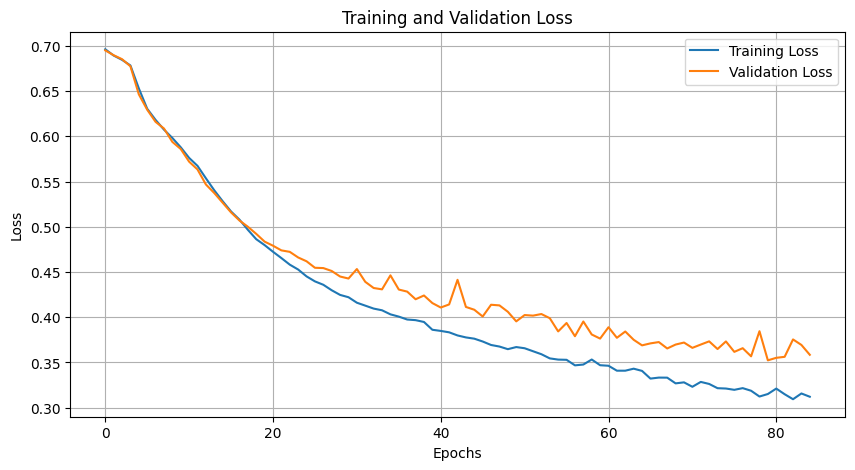

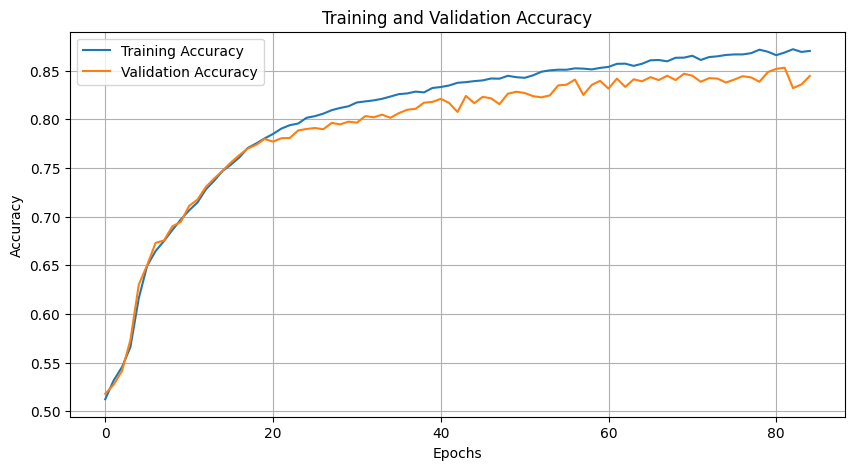

In [67]:


# Convert data to PyTorch tensors and move to device
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Define the Vanilla RNN model
class VanillaRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output = self.fc(output[:, -1, :])
        return torch.sigmoid(output)

# Set hyperparameters
input_size = frequentWord
embedding_dim = 64
hidden_size = 64
output_size = 1  # Assuming binary classification, hence 1 output neuron
learning_rate = 0.0001
weight_decay = 7e-4
dropout = 0.3
batch_size = 256
num_epochs = 85

# Instantiate the model and move to device
model = VanillaRNN(input_size, embedding_dim, hidden_size, output_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))

# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


#### Training Loss: 0.3121, Validation Loss: 0.3585, 
#### Train Accuracy: 0.8702, Validation Accuracy: 0.8445, Test Accuracy: 0.8445
#### Compute Time: 0.34 seconds

# Previous attempts

/tmp/ipykernel_632/3321725898.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_632/3321725898.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_632/3321725898.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_632/3321725898.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

Epoch 1/85, Loss: 0.6979, Validation Loss: 0.6952, Train Accuracy: 0.5063, Validation Accuracy: 0.5102
Epoch 2/85, Loss: 0.6904, Validation Loss: 0.6903, Train Accuracy: 0.5310, Validation Accuracy: 0.5425
Epoch 3/85, Loss: 0.6858, Validation Loss: 0.6869, Train Accuracy: 0.5519, Validation Accuracy: 0.5530
Epoch 4/85, Loss: 0.6819, Validation Loss: 0.6828, Train Accuracy: 0.5599, Validation Accuracy: 0.5555
Epoch 5/85, Loss: 0.6755, Validation Loss: 0.6682, Train Accuracy: 0.5744, Validation Accuracy: 0.5855
Epoch 6/85, Loss: 0.6513, Validation Loss: 0.6431, Train Accuracy: 0.6176, Validation Accuracy: 0.6375
Epoch 7/85, Loss: 0.6360, Validation Loss: 0.6420, Train Accuracy: 0.6436, Validation Accuracy: 0.6348
Epoch 8/85, Loss: 0.6283, Validation Loss: 0.6442, Train Accuracy: 0.6554, Validation Accuracy: 0.6388
Epoch 9/85, Loss: 0.6205, Validation Loss: 0.6286, Train Accuracy: 0.6627, Validation Accuracy: 0.6500
Epoch 10/85, Loss: 0.6123, Validation Loss: 0.6169, Train Accuracy: 0.672

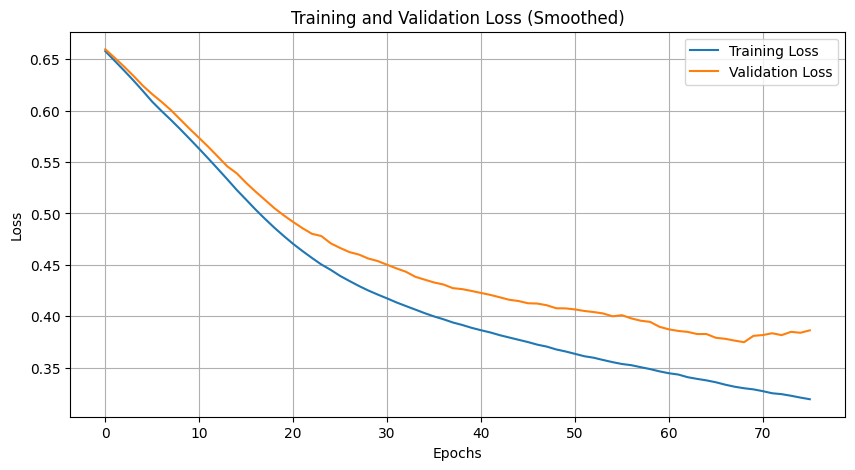

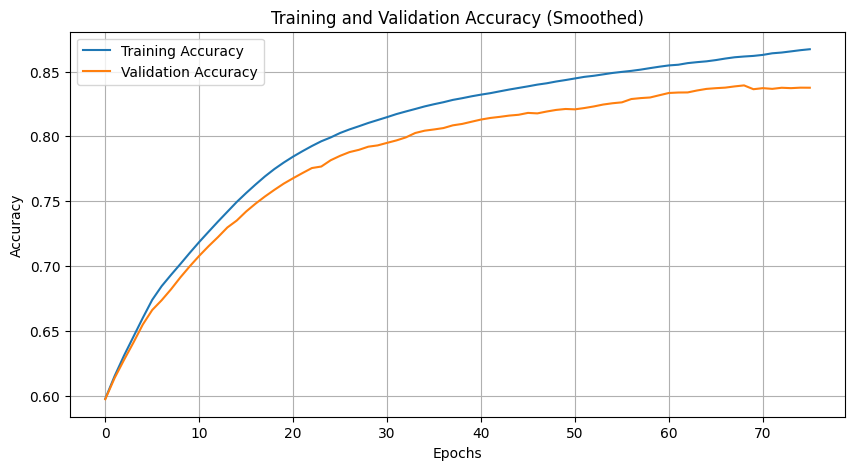

In [7]:


# Convert data to PyTorch tensors and move to device
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Define the Vanilla RNN model
class VanillaRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output = self.fc(output[:, -1, :])
        return torch.sigmoid(output)

# Set hyperparameters
input_size = frequentWord
embedding_dim = 64
hidden_size = 64
output_size = 1  # Assuming binary classification, hence 1 output neuron
learning_rate = 0.0001
weight_decay = 7e-4
dropout = 0.3
batch_size = 256
num_epochs = 85

# Instantiate the model and move to device
model = VanillaRNN(input_size, embedding_dim, hidden_size, output_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))

# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

import numpy as np

# Define a function to compute moving averages
def moving_average(data, window_size):
    weights = np.repeat(1.0, window_size) / window_size
    return np.convolve(data, weights, 'valid')

# Smoothened training and validation loss
smooth_train_losses = moving_average(train_losses, window_size=10)
smooth_val_losses = moving_average(val_losses, window_size=10)

# Smoothened training and validation accuracy
smooth_train_accuracies = moving_average(train_accuracies, window_size=10)
smooth_val_accuracies = moving_average(val_accuracies, window_size=10)

# Plotting training and validation loss with moving average
plt.figure(figsize=(10, 5))
plt.plot(smooth_train_losses, label='Training Loss')
plt.plot(smooth_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy with moving average
plt.figure(figsize=(10, 5))
plt.plot(smooth_train_accuracies, label='Training Accuracy')
plt.plot(smooth_val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()



Epoch 1/50, Loss: 0.6952, Validation Loss: 0.6912, Train Accuracy: 0.5174, Validation Accuracy: 0.5305
Epoch 2/50, Loss: 0.6867, Validation Loss: 0.6853, Train Accuracy: 0.5422, Validation Accuracy: 0.5513
Epoch 3/50, Loss: 0.6796, Validation Loss: 0.6785, Train Accuracy: 0.5639, Validation Accuracy: 0.5647
Epoch 4/50, Loss: 0.6620, Validation Loss: 0.6473, Train Accuracy: 0.5988, Validation Accuracy: 0.6332
Epoch 5/50, Loss: 0.6265, Validation Loss: 0.6244, Train Accuracy: 0.6518, Validation Accuracy: 0.6670
Epoch 6/50, Loss: 0.6036, Validation Loss: 0.6065, Train Accuracy: 0.6809, Validation Accuracy: 0.6793
Epoch 7/50, Loss: 0.5876, Validation Loss: 0.5922, Train Accuracy: 0.6960, Validation Accuracy: 0.6973
Epoch 8/50, Loss: 0.5739, Validation Loss: 0.5823, Train Accuracy: 0.7098, Validation Accuracy: 0.7060
Epoch 9/50, Loss: 0.5551, Validation Loss: 0.5742, Train Accuracy: 0.7270, Validation Accuracy: 0.7117
Epoch 10/50, Loss: 0.5422, Validation Loss: 0.5628, Train Accuracy: 0.737

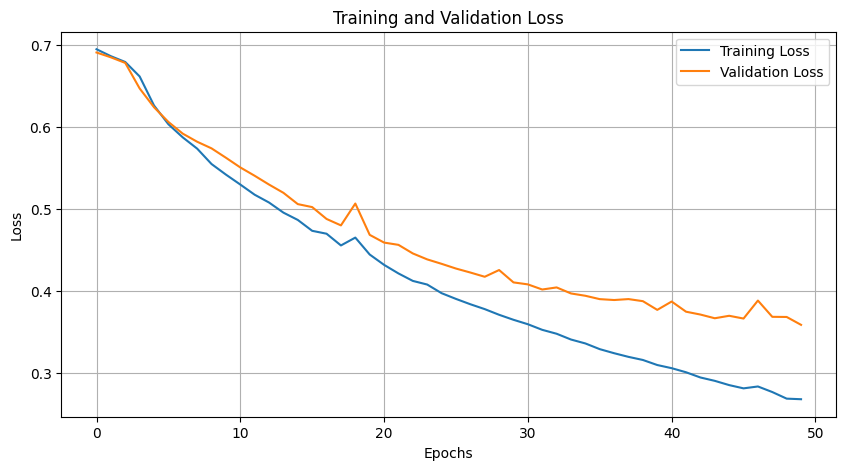

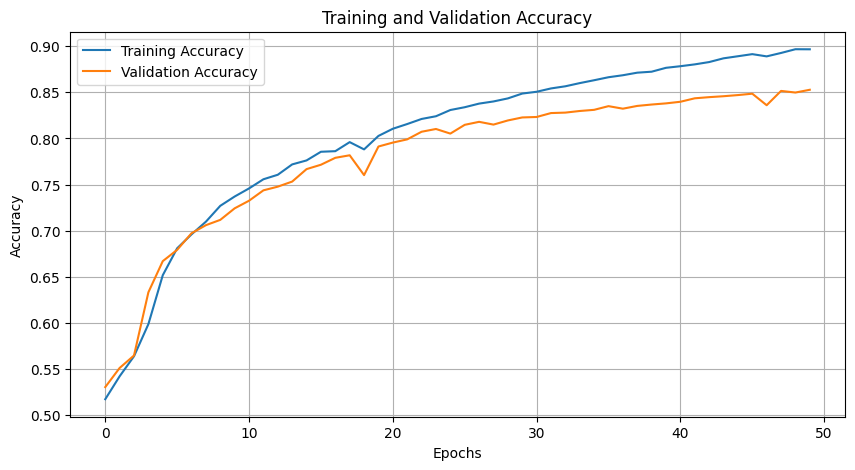

In [6]:


# Convert data to PyTorch tensors and move to device
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Define the Vanilla RNN model
class VanillaRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output = self.fc(output[:, -1, :])
        return torch.sigmoid(output)

# Set hyperparameters
input_size = frequentWord
embedding_dim = 64
hidden_size = 64
output_size = 1  # Assuming binary classification, hence 1 output neuron
learning_rate = 0.0001
weight_decay = 1e-5
dropout = 0.5
batch_size = 256
num_epochs = 50

# Instantiate the model and move to device
model = VanillaRNN(input_size, embedding_dim, hidden_size, output_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))

# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_25/1472687864.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_25/1472687864.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_25/1472687864.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_25/1472687864.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clo

Epoch 1/85, Loss: 0.6968, Validation Loss: 0.6941, Train Accuracy: 0.5147, Validation Accuracy: 0.5188
Epoch 2/85, Loss: 0.6882, Validation Loss: 0.6877, Train Accuracy: 0.5367, Validation Accuracy: 0.5425
Epoch 3/85, Loss: 0.6818, Validation Loss: 0.6822, Train Accuracy: 0.5607, Validation Accuracy: 0.5553
Epoch 4/85, Loss: 0.6718, Validation Loss: 0.6677, Train Accuracy: 0.5825, Validation Accuracy: 0.5860
Epoch 5/85, Loss: 0.6450, Validation Loss: 0.6484, Train Accuracy: 0.6280, Validation Accuracy: 0.6330
Epoch 6/85, Loss: 0.6304, Validation Loss: 0.6324, Train Accuracy: 0.6468, Validation Accuracy: 0.6450
Epoch 7/85, Loss: 0.6182, Validation Loss: 0.6204, Train Accuracy: 0.6629, Validation Accuracy: 0.6560
Epoch 8/85, Loss: 0.6081, Validation Loss: 0.6073, Train Accuracy: 0.6741, Validation Accuracy: 0.6750
Epoch 9/85, Loss: 0.5976, Validation Loss: 0.5966, Train Accuracy: 0.6852, Validation Accuracy: 0.6887
Epoch 10/85, Loss: 0.5883, Validation Loss: 0.5886, Train Accuracy: 0.696

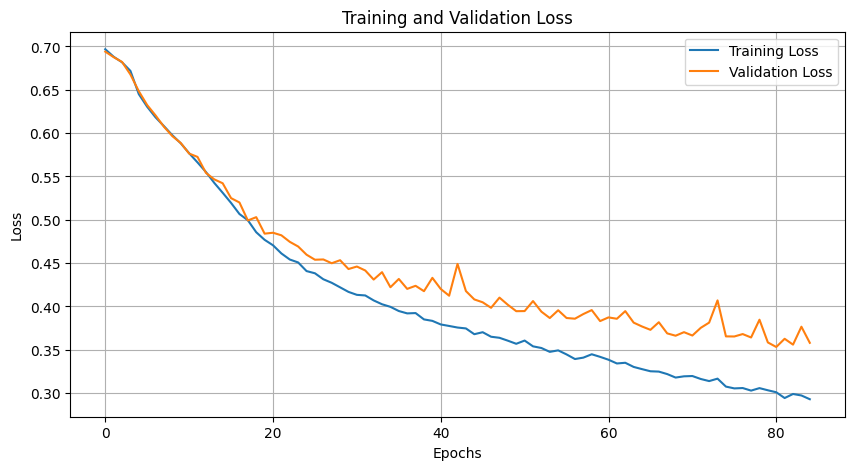

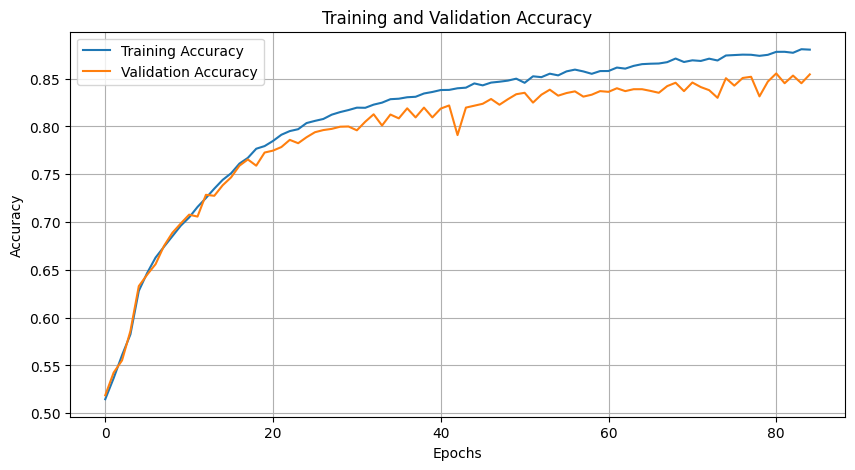

In [62]:


# Convert data to PyTorch tensors and move to device
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Define the Vanilla RNN model
class VanillaRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output = self.fc(output[:, -1, :])
        return torch.sigmoid(output)

# Set hyperparameters
input_size = frequentWord
embedding_dim = 64
hidden_size = 64
output_size = 1  # Assuming binary classification, hence 1 output neuron
learning_rate = 0.0001
weight_decay = 5e-4
dropout = 0.3
batch_size = 256
num_epochs = 85

# Instantiate the model and move to device
model = VanillaRNN(input_size, embedding_dim, hidden_size, output_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))

# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_25/2495680693.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_25/2495680693.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_25/2495680693.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_25/2495680693.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clo

Epoch 1/85, Loss: 0.6955, Validation Loss: 0.6895, Train Accuracy: 0.5210, Validation Accuracy: 0.5387
Epoch 2/85, Loss: 0.6884, Validation Loss: 0.6855, Train Accuracy: 0.5403, Validation Accuracy: 0.5443
Epoch 3/85, Loss: 0.6844, Validation Loss: 0.6829, Train Accuracy: 0.5546, Validation Accuracy: 0.5565
Epoch 4/85, Loss: 0.6808, Validation Loss: 0.6803, Train Accuracy: 0.5610, Validation Accuracy: 0.5605
Epoch 5/85, Loss: 0.6763, Validation Loss: 0.6757, Train Accuracy: 0.5726, Validation Accuracy: 0.5695
Epoch 6/85, Loss: 0.6653, Validation Loss: 0.6576, Train Accuracy: 0.5914, Validation Accuracy: 0.6028
Epoch 7/85, Loss: 0.6482, Validation Loss: 0.6390, Train Accuracy: 0.6203, Validation Accuracy: 0.6385
Epoch 8/85, Loss: 0.6363, Validation Loss: 0.6284, Train Accuracy: 0.6380, Validation Accuracy: 0.6510
Epoch 9/85, Loss: 0.6247, Validation Loss: 0.6162, Train Accuracy: 0.6532, Validation Accuracy: 0.6715
Epoch 10/85, Loss: 0.6114, Validation Loss: 0.6015, Train Accuracy: 0.668

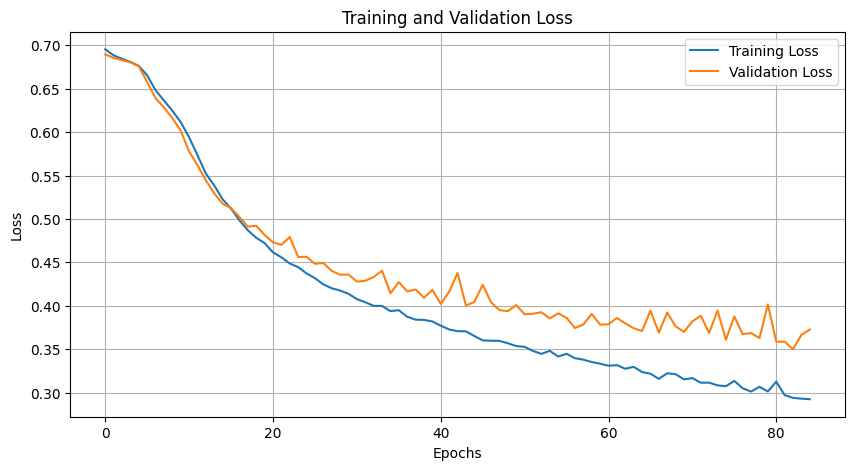

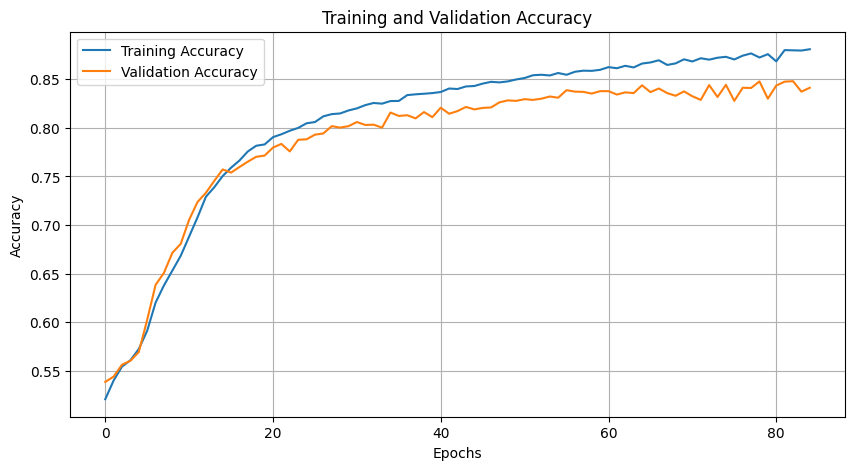

In [66]:


# Convert data to PyTorch tensors and move to device
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Define the Vanilla RNN model
class VanillaRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output = self.fc(output[:, -1, :])
        return torch.sigmoid(output)

# Set hyperparameters
input_size = frequentWord
embedding_dim = 64
hidden_size = 64
output_size = 1  # Assuming binary classification, hence 1 output neuron
learning_rate = 0.0001
weight_decay = 6e-4
dropout = 0.3
batch_size = 256
num_epochs = 85

# Instantiate the model and move to device
model = VanillaRNN(input_size, embedding_dim, hidden_size, output_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))

# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_25/150998637.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_25/150998637.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_25/150998637.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_25/150998637.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone()

Epoch 1/85, Loss: 0.6974, Validation Loss: 0.6936, Train Accuracy: 0.5108, Validation Accuracy: 0.5132
Epoch 2/85, Loss: 0.6891, Validation Loss: 0.6880, Train Accuracy: 0.5344, Validation Accuracy: 0.5363
Epoch 3/85, Loss: 0.6837, Validation Loss: 0.6836, Train Accuracy: 0.5519, Validation Accuracy: 0.5507
Epoch 4/85, Loss: 0.6782, Validation Loss: 0.6775, Train Accuracy: 0.5701, Validation Accuracy: 0.5655
Epoch 5/85, Loss: 0.6629, Validation Loss: 0.6415, Train Accuracy: 0.5999, Validation Accuracy: 0.6372
Epoch 6/85, Loss: 0.6356, Validation Loss: 0.6335, Train Accuracy: 0.6402, Validation Accuracy: 0.6410
Epoch 7/85, Loss: 0.6229, Validation Loss: 0.6290, Train Accuracy: 0.6578, Validation Accuracy: 0.6435
Epoch 8/85, Loss: 0.6158, Validation Loss: 0.6163, Train Accuracy: 0.6657, Validation Accuracy: 0.6663
Epoch 9/85, Loss: 0.6080, Validation Loss: 0.6046, Train Accuracy: 0.6739, Validation Accuracy: 0.6760
Epoch 10/85, Loss: 0.5990, Validation Loss: 0.5994, Train Accuracy: 0.683

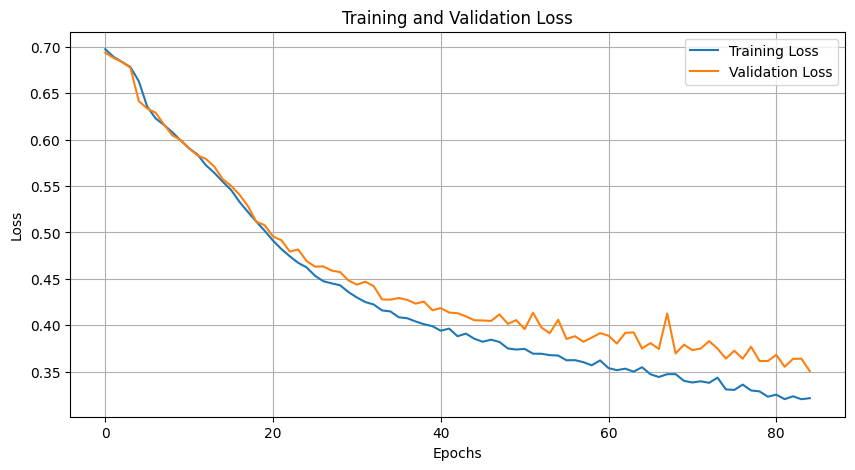

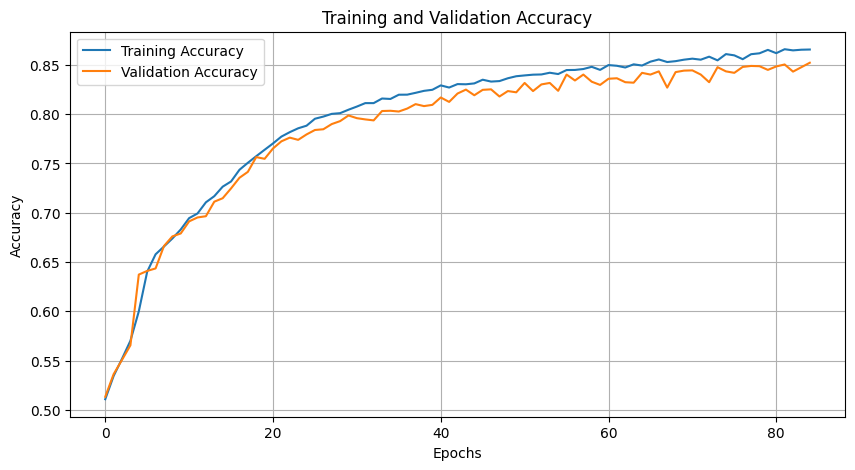

In [63]:


# Convert data to PyTorch tensors and move to device
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Define the Vanilla RNN model
class VanillaRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output = self.fc(output[:, -1, :])
        return torch.sigmoid(output)

# Set hyperparameters
input_size = frequentWord
embedding_dim = 64
hidden_size = 64
output_size = 1  # Assuming binary classification, hence 1 output neuron
learning_rate = 0.0001
weight_decay = 7e-4
dropout = 0.3
batch_size = 256
num_epochs = 85

# Instantiate the model and move to device
model = VanillaRNN(input_size, embedding_dim, hidden_size, output_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))

# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
